## Hualien Earthquake Project

#### 1. A list of events from USGS

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from libcomcat.search import search
from libcomcat.dataframes import get_summary_data_frame
import datetime
from datetime import timedelta

import geopy.distance

import obspy
from obspy import UTCDateTime
from obspy.taup import TauPyModel
from obspy.clients.fdsn import Client
from obspy.signal.trigger import plot_trigger
from obspy.signal.trigger import classic_sta_lta

from scipy.fftpack import fft, ifft, fftfreq, next_fast_len

In [2]:
events = search(starttime = datetime.datetime(2024, 4, 1, 0, 0), endtime = datetime.datetime(2024, 4, 3, 0, 0), minmagnitude = 6.5)
event_df = get_summary_data_frame(events)
event_df = event_df.sort_values(by = ['time'], ascending = False)
print('return %s events' % len(events))
event_df

return 1 events


,id,time,location,latitude,longitude,depth,magnitude,alert,url,eventtype,significance
0,us7000m9g4,2024-04-02 23:58:12.171,"15 km S of Hualien City, Taiwan",23.8353,121.5977,40,7.4,yellow,https://earthquake.usgs.gov/earthquakes/eventp...,earthquake,1399


In [5]:
hualien_event = event_df[event_df.id == 'us7000m9g4']
t0 = hualien_event.time.iloc[0]
t0_utc = UTCDateTime(t0)

In [6]:
# calculate distance for TATO
coord_1 = (hualien_event.latitude.to_numpy()[0], hualien_event.longitude.to_numpy()[0])
coord_2 = (24.974, 121.497) # TATO station 
distance_km = geopy.distance.geodesic(coord_1, coord_2).km
distance_deg = distance_km/40075*360 # Earth's circumference
print(f'Distance = {distance_km} km')

Distance = 126.53999355178782 km


In [8]:
# calculate distance for HUA3
coord_1 = (hualien_event.latitude.to_numpy()[0], hualien_event.longitude.to_numpy()[0])
coord_3 = (23.975, 121.614) # TATO station 
distance_km = geopy.distance.geodesic(coord_1, coord_3).km
distance_deg = distance_km/40075*360 # Earth's circumference
print(f'Distance = {distance_km} km')

Distance = 15.561499498239998 km


In [7]:
# calculate arrival time
model = TauPyModel(model = 'iasp91')
arrivals = model.get_travel_times(source_depth_in_km = hualien_event.depth.to_numpy()[0], 
                                  distance_in_degree = distance_deg)
print(f'Distance = {distance_deg} deg \nArrival time = {arrivals[0].time} sec after source time')

Distance = 1.1367285758863035 deg 
Arrival time = 19.407916606013448 sec after source time


In [6]:
t0 = t0 + timedelta(seconds=arrivals[0].time) #  the travel time of the seismic wave
t0 = t0 - timedelta(minutes=5) # to capture some data before the arrival of the seismic waves

#### 2. Waveform analysis

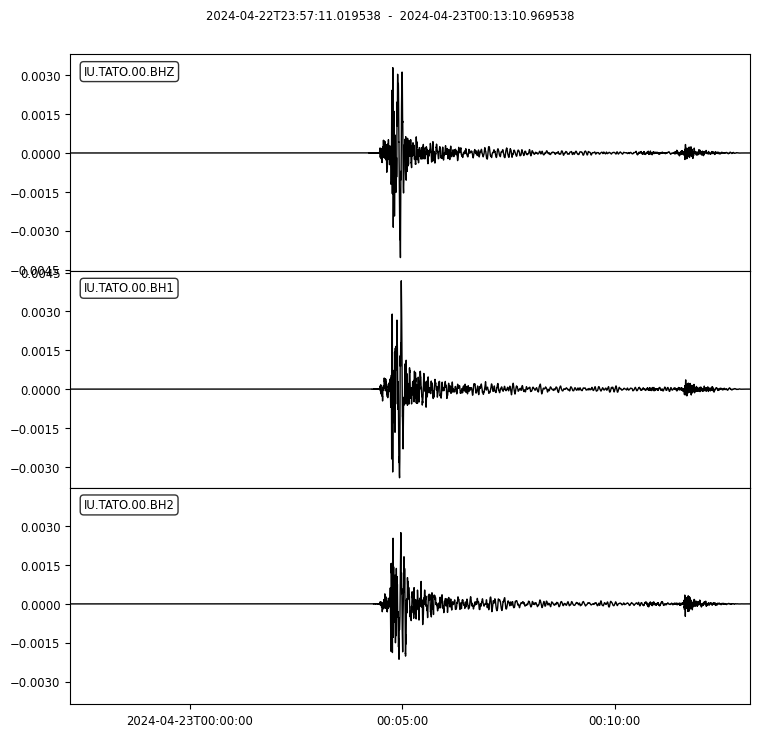

In [81]:
client = Client('IRIS')
time = UTCDateTime('2024-04-22T23:58:11')
starttime = time - 60
endtime = time + 60*15
net='IU'; sta='TATO'; loc='00'; chan='BH*'
Z = client.get_waveforms(net,sta,loc,chan, starttime, endtime, attach_response=True)
Z.remove_response(output='VEL')
Z.merge()
Z.detrend(type='linear')
Z.taper(max_percentage=0.05)
Z.plot();

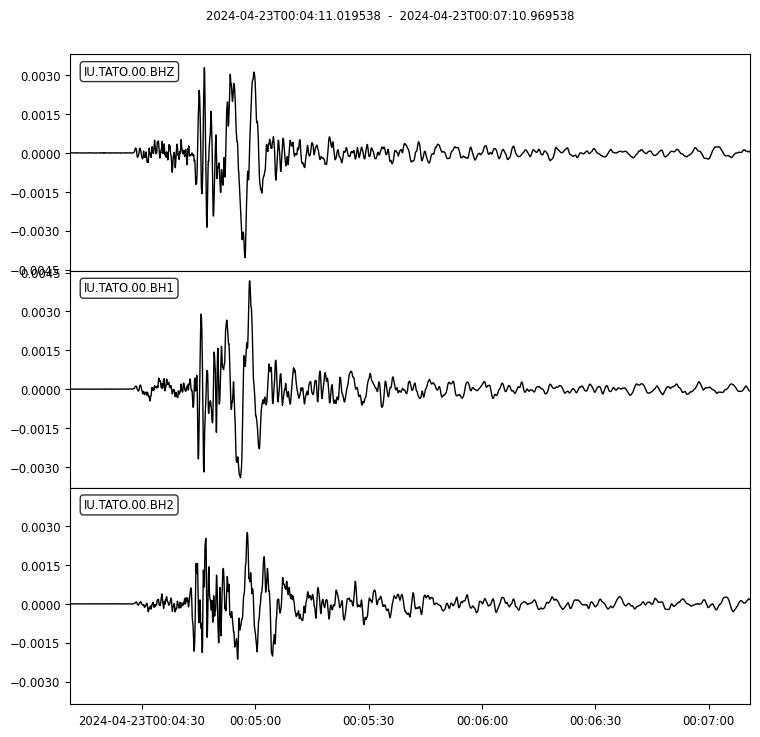

In [91]:
# trimming data
starttime_ = Z[0].stats.starttime + 7*60
endtime_ = Z[0].stats.endtime - 6*60
Z_trim = Z.copy()
Z_trim.trim(starttime=starttime_, endtime=endtime_)
Z_trim.plot();

In [83]:
Z[0].stats

               network: IU
               station: TATO
              location: 00
               channel: BH1
             starttime: 2024-04-22T23:57:11.019538Z
               endtime: 2024-04-23T00:13:10.969538Z
         sampling_rate: 20.0
                 delta: 0.05
                  npts: 19200
                 calib: 1.0
_fdsnws_dataselect_url: http://service.iris.edu/fdsnws/dataselect/1/query
               _format: MSEED
                 mseed: AttribDict({'dataquality': 'M', 'number_of_records': 116, 'encoding': 'STEIM2', 'byteorder': '>', 'record_length': 512, 'filesize': 176128})
            processing: ['ObsPy 1.4.0: trim(endtime=UTCDateTime(2024, 4, 23, 0, 13, 11, 19538)::fill_value=None::nearest_sample=True::pad=False::starttime=UTCDateTime(2024, 4, 22, 23, 57, 11, 19538))', "ObsPy 1.4.0: remove_response(fig=None::inventory=None::output='VEL'::plot=False::pre_filt=None::taper=True::taper_fraction=0.05::water_level=60::zero_mean=True)", "ObsPy 1.4.0: detrend(options={}::

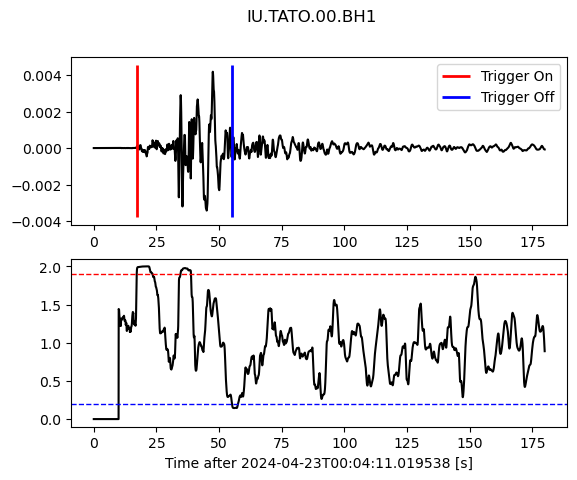

In [93]:
df = Z_trim[0].stats.sampling_rate
cft = classic_sta_lta(Z_trim[0].data, int(5 * df), int(10 * df))
plot_trigger(Z_trim[0], cft, 1.9, 0.2)

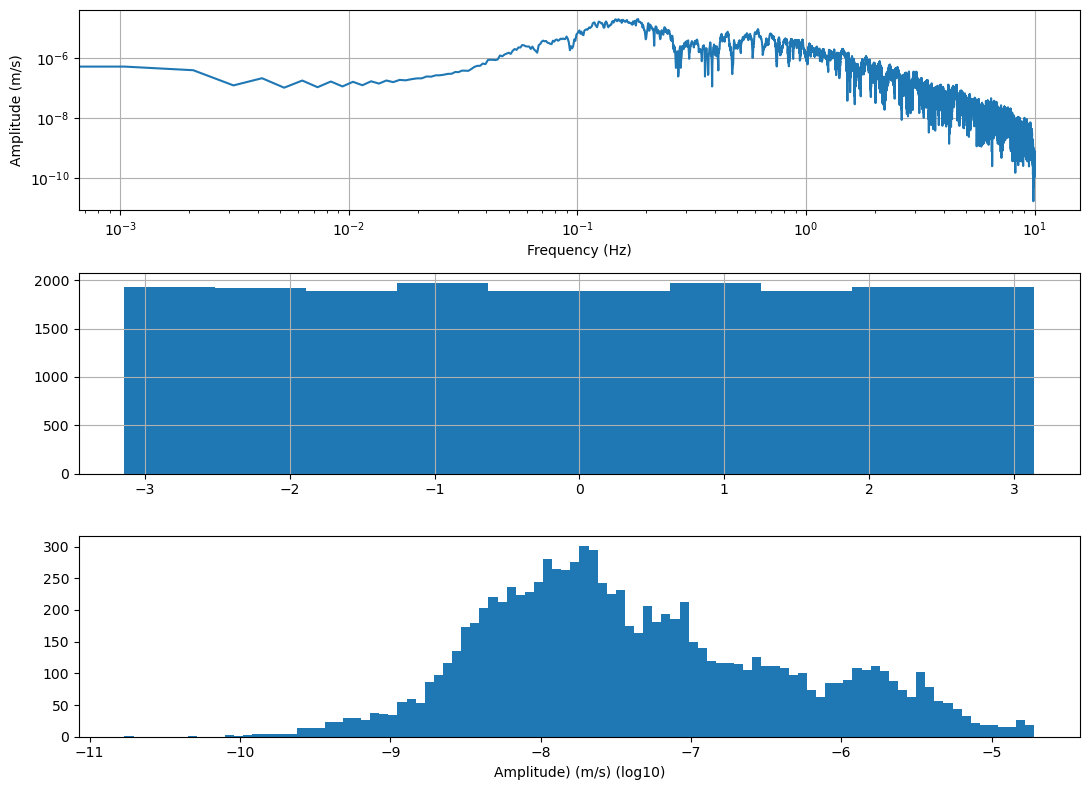

In [13]:
# fast fourier transform
npts = Z[0].stats.npts
Nfft = next_fast_len(int(Z[0].data.shape[0]))
freqVec = fftfreq(Nfft, d=Z[0].stats.delta)[:Nfft//2]
Zhat =  fft(Z[0].data, n=Nfft)

fig, ax = plt.subplots(3, 1, figsize=(11, 8))
ax[0].plot(freqVec, np.abs(Zhat[:Nfft//2])/Nfft)
ax[0].grid(True)
ax[0].set_xscale('log');ax[0].set_yscale('log')
ax[0].set_xlabel('Frequency (Hz)');ax[0].set_ylabel('Amplitude (m/s)')
ax[1].hist(np.angle(Zhat))
ax[1].grid(True)
ax[2].hist(np.log10(np.abs(Zhat[:Nfft//2])/Nfft),100)
ax[2].set_xlabel('Amplitude) (m/s) (log10)')
plt.tight_layout()

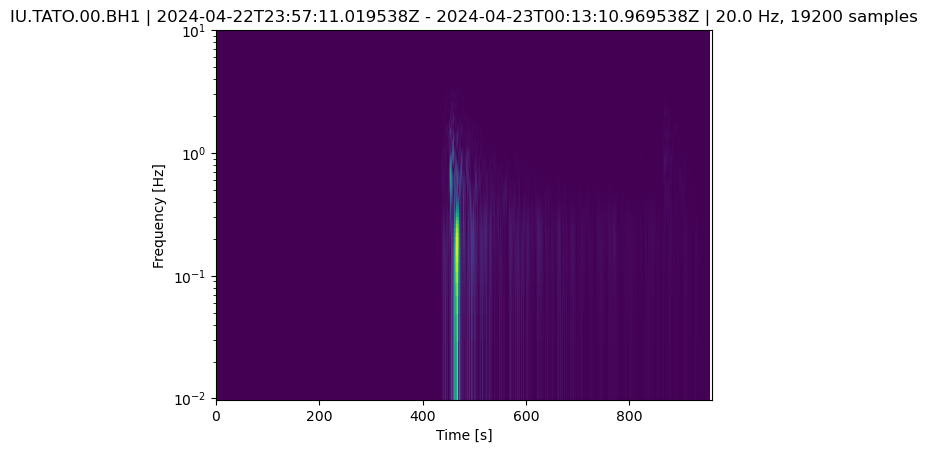

In [14]:
Z[0].spectrogram(log=True)

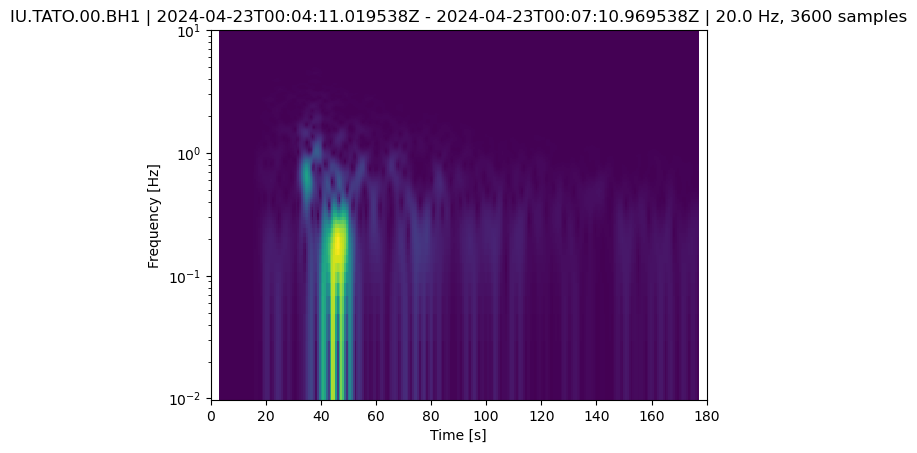

In [94]:
Z_trim[0].spectrogram(log=True)

#### 3. Seismic event characteristics

In [16]:
# moment rate 
# data from https://earthquake.usgs.gov/earthquakes/eventpage/us7000m9g4/finite-fault
mr_url = 'https://raw.githubusercontent.com/Benz-Poobua/Hualien-Earthquake-analysis/47c400702cc341d69964b2ff2cd9a7f40726df5c/moment_rate.mr'
mr = pd.read_csv(mr_url, header=None, delim_whitespace=True, names=['Time', 'MR'], skiprows=2)
print(mr)

       Time            MR
0      0.00  0.000000e+00
1      0.01  4.427200e+11
2      0.02  2.213400e+12
3      0.03  6.196800e+12
4      0.04  1.327600e+13
...     ...           ...
6896  68.96  0.000000e+00
6897  68.97  0.000000e+00
6898  68.98  0.000000e+00
6899  68.99  0.000000e+00
6900  69.00  0.000000e+00

[6901 rows x 2 columns]


Max moment rate =  1.1741e+19 Nm/s


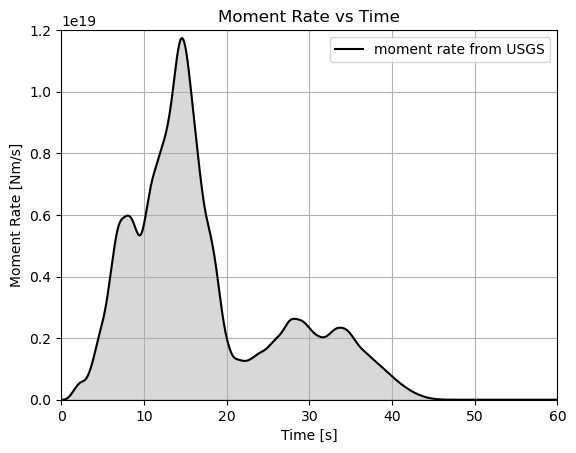

In [39]:
fig = plt.figure()
max_MR = mr['MR'].max()
print('Max moment rate = ', max_MR, 'Nm/s')
plt.plot(mr.Time, mr.MR, label='moment rate from USGS', c='black')
plt.xlim(0,60)
plt.ylim(0,1.2e19)
plt.fill_between(mr['Time'], mr['MR'], color='gray', alpha=0.3)  # Fill area under the curve with gray
plt.legend(loc="upper right")
plt.title('Moment Rate vs Time')
plt.xlabel('Time [s]')
plt.ylabel('Moment Rate [Nm/s]')
plt.grid(True)
plt.show()

In [18]:
# find the start time when mr.MR = 0
start_time_zero_MR = mr.loc[mr['MR'] == 0, 'Time'].iloc[1] # not the first
print("Start time when MR = 0:", start_time_zero_MR, "s")

Start time when MR = 0: 48.79 s


In [20]:
# calculate seismic moment
# calculate the time step (assuming uniform time intervals)
dt = mr.Time.diff().mean()
# Integrate the moment rate with respect to time using the trapezoidal rule
area_under_curve = np.trapz(mr.MR, dx=dt)
M0 = area_under_curve
print("M0:", M0, "Nm")

M0: 1.4392766715855176e+20 Nm


By the empirical relationship, $M_w = \frac{2}{3}(log_{10}{M_0}-9.1)$

In [21]:
Mw = (2/3)*(np.log10(M0)-9.1)
print("Mw:", Mw)

Mw: 7.372096190812169


#### 4. GPS data visualization

# add NGL info

/var/folders/vn/yw43vwrj3nsglb002nc_3s6w0000gn/T/ipykernel_16560/2812883864.py:31: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


The Mw 7.4 Hualien earthquake has caused 
a westward motion of -2.22 cm 
a southward motion of 8.02 cm 
an uplift of 42.75 cm 
at the GPS station HUA3.


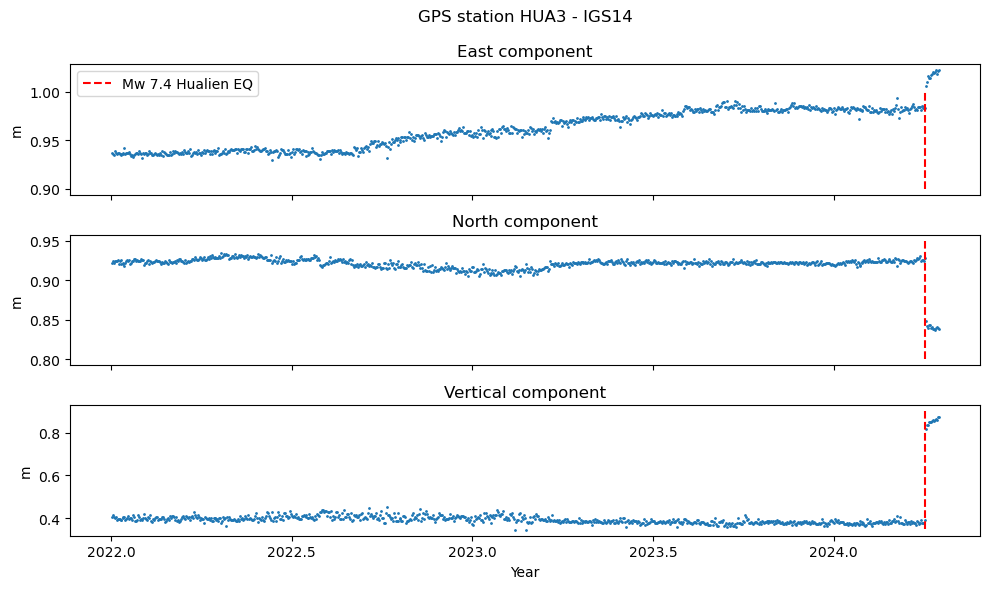

In [22]:
# HUA3 gps station from http://geodesy.unr.edu/NGLStationPages/stations/HUA3.sta
gps_url = 'http://geodesy.unr.edu/gps_timeseries/tenv3/IGS14/HUA3.tenv3'
gps = pd.read_csv(gps_url, sep='\s+')

fig, ax = plt.subplots(3,1, figsize=(10,6), sharex = True)

recent_gps = gps[gps['yyyy.yyyy'] >= 2022.0]

event = 2024.2521
ax[0].set_title("GPS station HUA3 - IGS14\n\nEast component")
ax[0].plot(recent_gps['yyyy.yyyy'], recent_gps['__east(m)'], 'o', markersize=1)
ax[0].set_ylabel("m")
ax[0].vlines(x=event, ymin=0.9, ymax=1.0, label="Mw 7.4 Hualien EQ",
          colors='r', linestyles='dashed')
ax[0].legend(loc="upper left")

ax[1].set_title("North component")
ax[1].plot(recent_gps['yyyy.yyyy'], recent_gps['_north(m)'], 'o', markersize=1)
ax[1].set_ylabel("m")
ax[1].vlines(x=event, ymin=0.8, ymax=0.95, label="Mw 7.4 Hualien EQ",
          colors='r', linestyles='dashed')

ax[2].set_title("Vertical component")
ax[2].plot(recent_gps['yyyy.yyyy'], recent_gps['____up(m)'], 'o', markersize=1)
ax[2].set_ylabel("m")
ax[2].set_xlabel("Year")
ax[2].vlines(x=event, ymin=0.35, ymax=0.9, label="Mw 7.4 Hualien EQ",
          colors='r', linestyles='dashed')

fig.tight_layout()
fig.show()

print('''The Mw 7.4 Hualien earthquake has caused \na westward motion of {:.2f} cm \na southward motion of {:.2f} cm \nan uplift of {:.2f} cm \nat the GPS station {}.'''
      .format((gps["__east(m)"][gps[gps['YYMMMDD'].str.match('24APR02')].index[0]] 
             - gps["__east(m)"][gps[gps['YYMMMDD'].str.match('24APR03')].index[0]]) * 100,
              (gps["_north(m)"][gps[gps['YYMMMDD'].str.match('24APR02')].index[0]] 
             - gps["_north(m)"][gps[gps['YYMMMDD'].str.match('24APR03')].index[0]]) * 100,
              abs(gps["____up(m)"][gps[gps['YYMMMDD'].str.match('24APR02')].index[0]] 
             - gps["____up(m)"][gps[gps['YYMMMDD'].str.match('24APR03')].index[0]]) * 100,
              gps["site"].iloc[0]))

#### 5. Tide Gauge data visualization

# add IOC data

In [25]:
# metadata of stations from Intergovernmental Oceanographic Commission (IOC)

# Taiwan
thua_meta = pd.read_html('http://www.t.org/station.php?code=thua')[8]
tshi_meta = pd.read_html('http://www.ioc-sealevelmonitoring.org/station.php?code=tshi')[8]
thep_meta = pd.read_html('http://www.ioc-sealevelmonitoring.org/station.php?code=thep')[8]
txig_meta = pd.read_html('http://www.ioc-sealevelmonitoring.org/station.php?code=txig')[8]
tsua_meta = pd.read_html('http://www.ioc-sealevelmonitoring.org/station.php?code=tsua')[8]
twus_meta = pd.read_html('http://www.ioc-sealevelmonitoring.org/station.php?code=twus')[8]

# Japan
ishig_meta = pd.read_html('http://www.ioc-sealevelmonitoring.org/station.php?code=ishig')[8]
naha_meta = pd.read_html('http://www.ioc-sealevelmonitoring.org/station.php?code=naha')[8]

#Philippines
curri_meta = pd.read_html('http://www.ioc-sealevelmonitoring.org/station.php?code=curri')[8]

In [26]:
thua_meta

,Station metadata,Station metadata.1
0,Code,thua
1,Country,Taiwan (Province of China)
2,Location,Hualien
3,Status,Operational
4,Local Contact,Central Weather Administration ( Taiwan )
5,Long-term MSL data,NaN
6,Latitude,23.9806
7,Longitude,121.6236
8,Connection,WEB service
9,Sensor 1,Sensor 1


In [62]:
# period: 2024-04-03 (day)
# remove outliers and spikes
# absolute level (as received) or sealevel

# Taiwan
thua1 = pd.read_html('https://www.ioc-sealevelmonitoring.org/bgraph.php?code=thua&output=tab&period=1&endtime=2024-04-03', header=0)[0]
thua1['Time (UTC)'] = pd.to_datetime(thua1['Time (UTC)'])
thua2 = pd.read_html('https://www.ioc-sealevelmonitoring.org/bgraph.php?code=thua&output=tab&period=1&endtime=2024-04-04', header=0)[0]
thua2['Time (UTC)'] = pd.to_datetime(thua2['Time (UTC)'])
thua = pd.concat([thua1, thua2])
thua.reset_index(drop=True, inplace=True)

tshi1 = pd.read_html('https://www.ioc-sealevelmonitoring.org/bgraph.php?code=tshi&output=tab&period=1&endtime=2024-04-03', header=0)[0]
tshi1['Time (UTC)'] = pd.to_datetime(tshi1['Time (UTC)'])
tshi2 = pd.read_html('https://www.ioc-sealevelmonitoring.org/bgraph.php?code=tshi&output=tab&period=1&endtime=2024-04-04', header=0)[0]
tshi2['Time (UTC)'] = pd.to_datetime(tshi2['Time (UTC)'])
tshi = pd.concat([tshi1, tshi2])
tshi.reset_index(drop=True, inplace=True)

thep1 = pd.read_html('https://www.ioc-sealevelmonitoring.org/bgraph.php?code=thep&output=tab&period=1&endtime=2024-04-03', header=0)[0]
thep1['Time (UTC)'] = pd.to_datetime(thep1['Time (UTC)'])
thep2 = pd.read_html('https://www.ioc-sealevelmonitoring.org/bgraph.php?code=thep&output=tab&period=1&endtime=2024-04-04', header=0)[0]
thep2['Time (UTC)'] = pd.to_datetime(thep2['Time (UTC)'])
thep = pd.concat([thep1, thep2])
thep.reset_index(drop=True, inplace=True)

txig1 = pd.read_html('https://www.ioc-sealevelmonitoring.org/bgraph.php?code=txig&output=tab&period=1&endtime=2024-04-03', header=0)[0]
txig1['Time (UTC)'] = pd.to_datetime(txig1['Time (UTC)'])
txig2 = pd.read_html('https://www.ioc-sealevelmonitoring.org/bgraph.php?code=txig&output=tab&period=1&endtime=2024-04-04', header=0)[0]
txig2['Time (UTC)'] = pd.to_datetime(txig2['Time (UTC)'])
txig = pd.concat([txig1, txig2])
txig.reset_index(drop=True, inplace=True)

tsua1 = pd.read_html('https://www.ioc-sealevelmonitoring.org/bgraph.php?code=tsua&output=tab&period=1&endtime=2024-04-03', header=0)[0]
tsua1['Time (UTC)'] = pd.to_datetime(tsua1['Time (UTC)'])
tsua2 = pd.read_html('https://www.ioc-sealevelmonitoring.org/bgraph.php?code=tsua&output=tab&period=1&endtime=2024-04-04', header=0)[0]
tsua2['Time (UTC)'] = pd.to_datetime(tsua2['Time (UTC)'])
tsua = pd.concat([tsua1, tsua2])
tsua.reset_index(drop=True, inplace=True)

twus1 = pd.read_html('https://www.ioc-sealevelmonitoring.org/bgraph.php?code=twus&output=tab&period=1&endtime=2024-04-03', header=0)[0]
twus1['Time (UTC)'] = pd.to_datetime(twus1['Time (UTC)'])
twus2 = pd.read_html('https://www.ioc-sealevelmonitoring.org/bgraph.php?code=twus&output=tab&period=1&endtime=2024-04-04', header=0)[0]
twus2['Time (UTC)'] = pd.to_datetime(twus2['Time (UTC)'])
twus = pd.concat([twus1, twus2])
twus.reset_index(drop=True, inplace=True)

#--------------------------------------------#
# Japan
ishig1 = pd.read_html('https://www.ioc-sealevelmonitoring.org/bgraph.php?code=ishig&output=tab&period=1&endtime=2024-04-03', header=0)[0]
ishig1['Time (UTC)'] = pd.to_datetime(ishig1['Time (UTC)'])
ishig2 = pd.read_html('https://www.ioc-sealevelmonitoring.org/bgraph.php?code=ishig&output=tab&period=1&endtime=2024-04-04', header=0)[0]
ishig2['Time (UTC)'] = pd.to_datetime(ishig2['Time (UTC)'])
ishig = pd.concat([ishig1, ishig2])
ishig.reset_index(drop=True, inplace=True)

naha1 = pd.read_html('https://www.ioc-sealevelmonitoring.org/bgraph.php?code=naha&output=tab&period=1&endtime=2024-04-03', header=0)[0]
naha1['Time (UTC)'] = pd.to_datetime(naha1['Time (UTC)'])
naha2 = pd.read_html('https://www.ioc-sealevelmonitoring.org/bgraph.php?code=naha&output=tab&period=1&endtime=2024-04-04', header=0)[0]
naha2['Time (UTC)'] = pd.to_datetime(naha2['Time (UTC)'])
naha = pd.concat([naha1, naha2])
naha.reset_index(drop=True, inplace=True)

# Philippines
curri1 = pd.read_html('https://www.ioc-sealevelmonitoring.org/bgraph.php?code=curri&output=tab&period=1&endtime=2024-04-03', header=0)[0]
curri1['Time (UTC)'] = pd.to_datetime(curri1['Time (UTC)'])
curri2 = pd.read_html('https://www.ioc-sealevelmonitoring.org/bgraph.php?code=curri&output=tab&period=1&endtime=2024-04-04', header=0)[0]
curri2['Time (UTC)'] = pd.to_datetime(curri2['Time (UTC)'])
curri = pd.concat([curri1, curri2])
curri = curri[['Time (UTC)', 'rad(m)']]
curri.dropna(inplace=True)
curri.reset_index(drop=True, inplace=True)

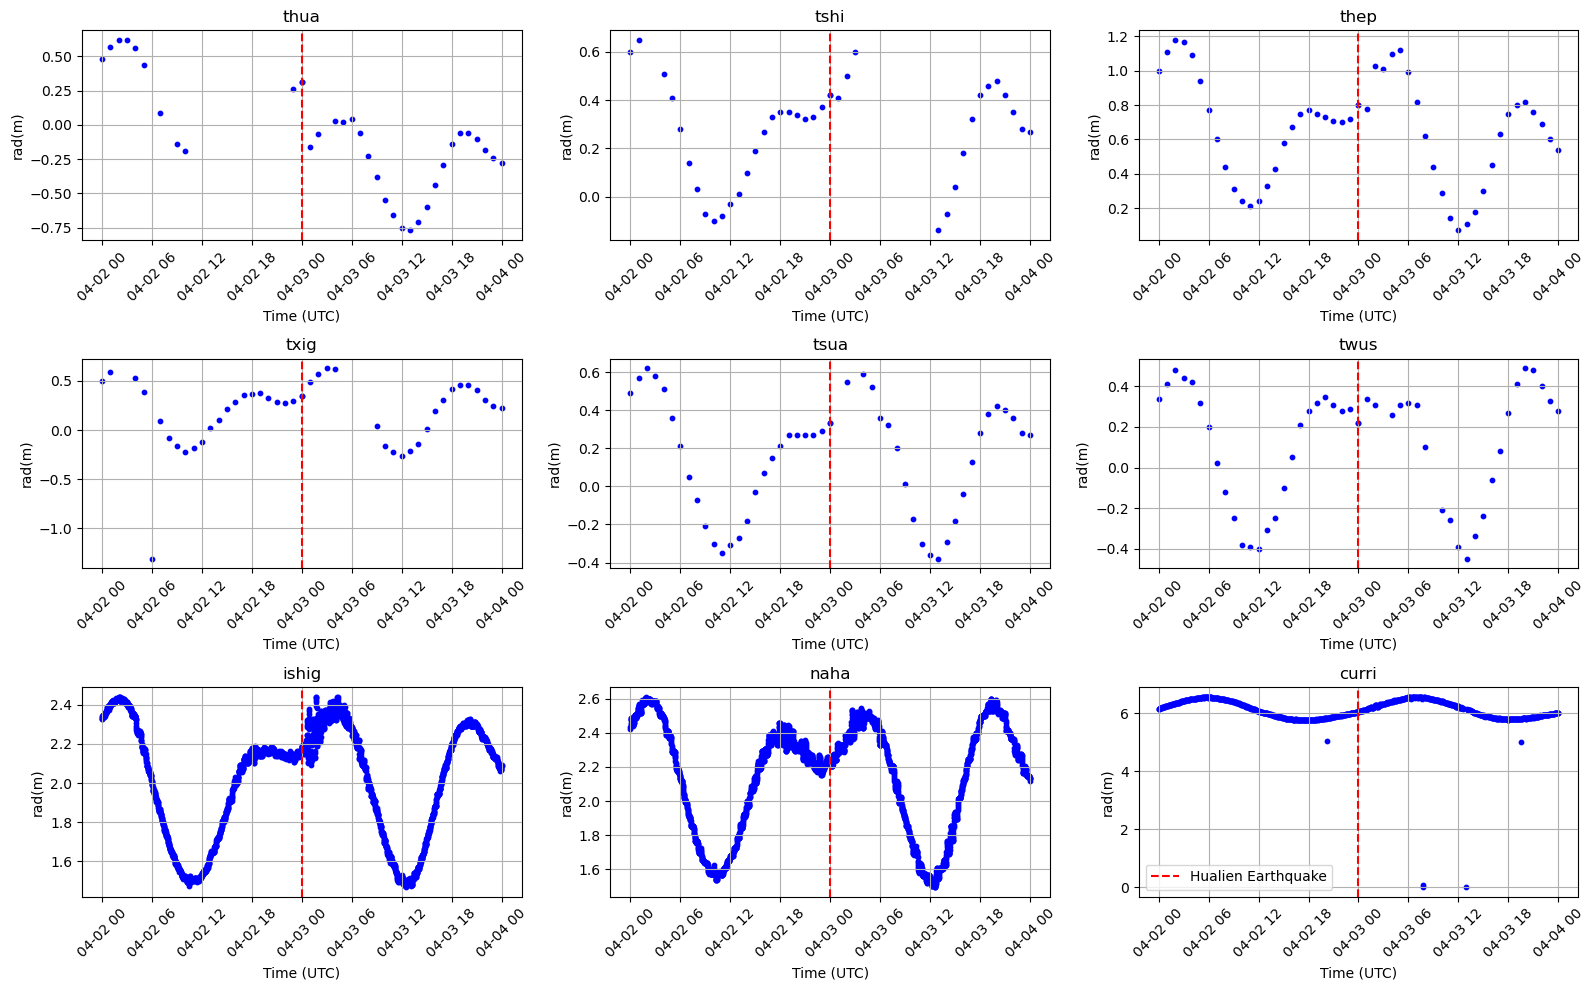

In [63]:
fig, axs = plt.subplots(3, 3, figsize=(16, 10))

# Convert event time to datetime object
event_time = pd.to_datetime('2024-04-02 23:58:12')

locations = [(thua, 'thua'), (tshi, 'tshi'), (thep, 'thep'), (txig, 'txig'), (tsua, 'tsua'), (twus, 'twus'), (ishig, 'ishig'), (naha, 'naha'), (curri, 'curri')]
# Plot data for each location
for i, (data, location) in enumerate(locations):
    row = i // 3
    col = i % 3
    axs[row, col].scatter(data['Time (UTC)'], data['rad(m)'], marker='o', color='blue', s=10)
    axs[row, col].set_title(location)
    axs[row, col].tick_params(axis='x', rotation=45)  # Rotate x-axis labels
    axs[row, col].set_xlabel('Time (UTC)')
    axs[row, col].set_ylabel('rad(m)')
    axs[row, col].grid(True)

    #axs[row, col].set_ylim(-0.8, 1.3)
    axs[row, col].axvline(x=event_time, color='red', linestyle='--', label='Hualien Earthquake')

# Add legend
axs[-1, 2].legend(loc='lower left')

# Adjust layout
plt.tight_layout()
plt.show()

# add Remarks

In [27]:
def filtered_tidegauge(df, df_meta, ax):
    starttime_tg = UTCDateTime(df["Time (UTC)"].iloc[0])
    endtime_tg = UTCDateTime(df["Time (UTC)"].iloc[-1])
    sealevel = df["rad(m)"].to_numpy()
    length = len(df)
    tr = obspy.core.Trace(data=sealevel)   
    tr.stats.network = "IU"
    tr.stats.station = df_meta["Station metadata.1"][df_meta[df_meta['Station metadata'].str.match('Code')].index[0]].upper()
    tr.stats.delta = (endtime_tg - starttime_tg) / (length-1)
    tr.stats.starttime = starttime_tg
    ftr = tr.copy()
    ftr.trim(starttime=t0_utc, endtime=t0_utc+60*60*4)
    ftr.filter(type="highpass", freq=3.5e-5, zerophase=True)
    t = np.linspace(0, 4, ftr.stats.npts)
    ax.plot(t, ftr.data, 'b')
    ax.set_xlim(t[0], t[-1])
    ax.set_title("{}".format(df_meta["Station metadata.1"][df_meta[df_meta['Station metadata'].str.match('Location')].index[0]])) 
    return ax

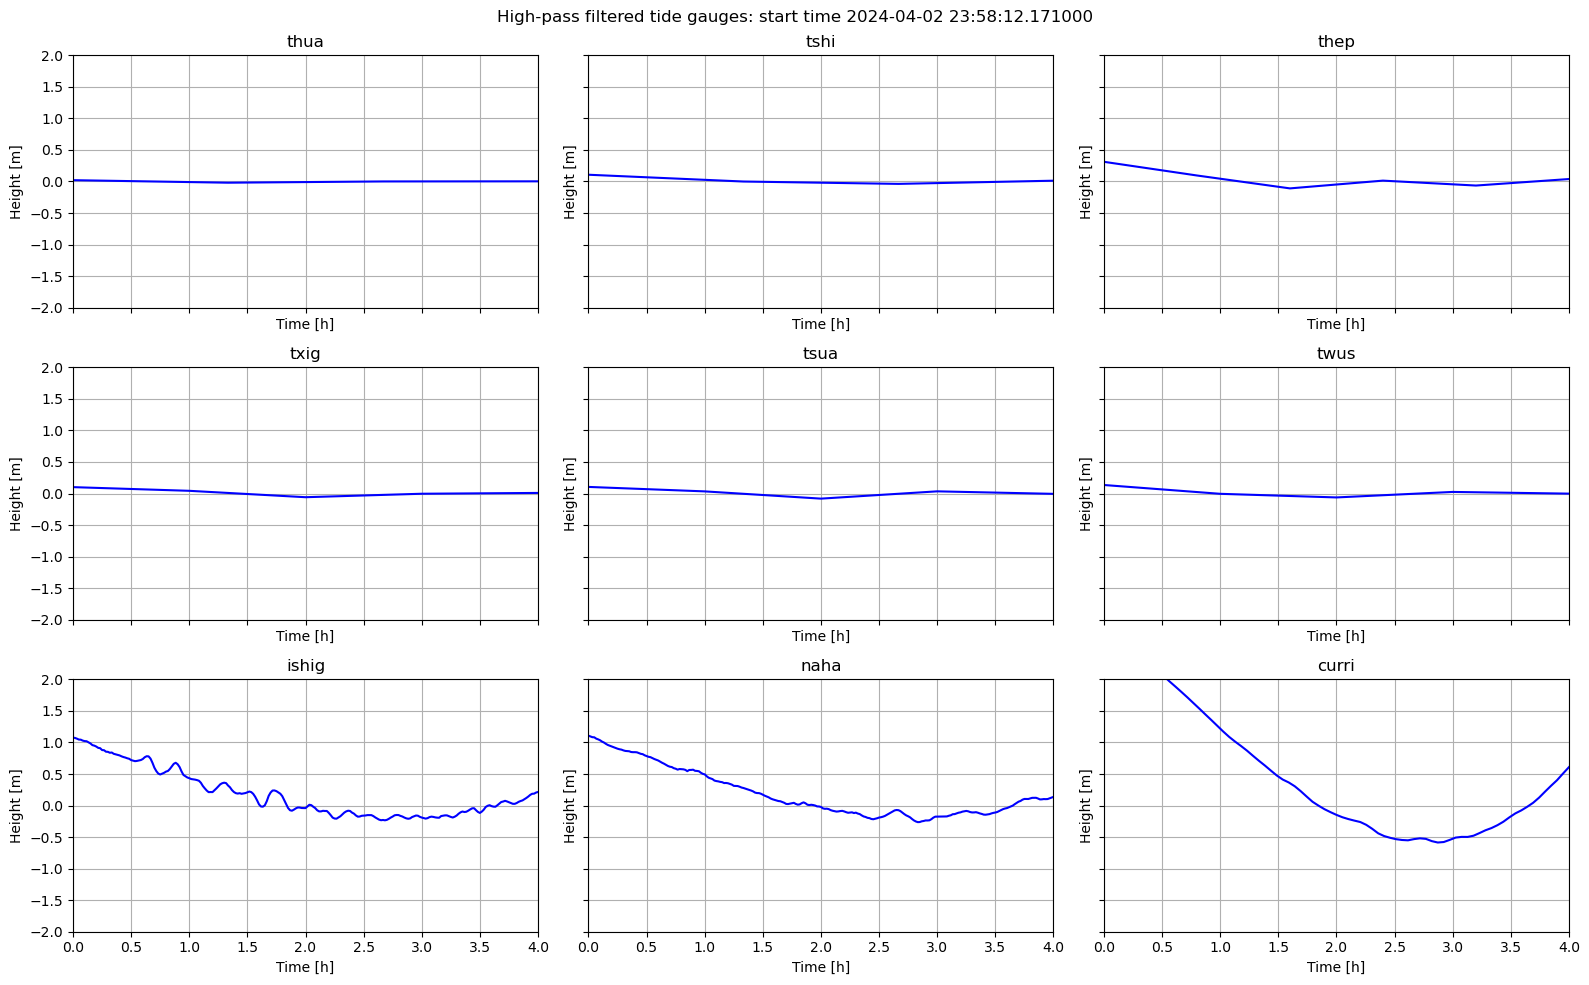

In [30]:
# high pass filter
fig, axs = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(16, 10))
fig.suptitle("High-pass filtered tide gauges: start time {}".format(t0_utc.datetime))

# Set y-axis limits for the first subplot
axs[0, 0].set_ylim(-2, 2)

locations = [(thua, thua_meta, 'thua'), (tshi, tshi_meta, 'tshi'), (thep, thep_meta, 'thep'), (txig, txig_meta, 'txig'), (tsua, tsua_meta, 'tsua'), (twus, twus_meta, 'twus'), (ishig, ishig_meta, 'ishig'), (naha, naha_meta, 'naha'), (curri, curri_meta, 'curri')]

# Call filtered_tidegauge function for each location
for i, (data, meta, location) in enumerate(locations):
    row = i // 3
    col = i % 3
    filtered_tidegauge(data, meta, axs[row, col])
    axs[row, col].set_title(location)
    axs[row, col].set_xlabel('Time [h]')
    axs[row, col].set_ylabel('Height [m]')
    axs[row, col].grid(True)

# Adjust layout
plt.tight_layout()
plt.show()

# add Remarks

# add stack of 5 yrs of Japan stations

In [40]:
# ishig station from 2019 to 2023
ishig2019_1 = pd.read_html('https://www.ioc-sealevelmonitoring.org/bgraph.php?code=ishig&output=tab&period=1&endtime=2019-04-03', header=0)[0]
ishig2019_1 ['Time (UTC)'] = pd.to_datetime(ishig1['Time (UTC)'])
ishig2019_2  = pd.read_html('https://www.ioc-sealevelmonitoring.org/bgraph.php?code=ishig&output=tab&period=1&endtime=2019-04-04', header=0)[0]
ishig2019_2 ['Time (UTC)'] = pd.to_datetime(ishig2['Time (UTC)'])
ishig2019  = pd.concat([ishig2019_1, ishig2019_2])
ishig2019.reset_index(drop=True, inplace=True)

ishig2020_1 = pd.read_html('https://www.ioc-sealevelmonitoring.org/bgraph.php?code=ishig&output=tab&period=1&endtime=2020-04-03', header=0)[0]
ishig2020_1 ['Time (UTC)'] = pd.to_datetime(ishig1['Time (UTC)'])
ishig2020_2  = pd.read_html('https://www.ioc-sealevelmonitoring.org/bgraph.php?code=ishig&output=tab&period=1&endtime=2020-04-04', header=0)[0]
ishig2020_2 ['Time (UTC)'] = pd.to_datetime(ishig2['Time (UTC)'])
ishig2020  = pd.concat([ishig2020_1, ishig2020_2])
ishig2020.reset_index(drop=True, inplace=True)

ishig2021_1 = pd.read_html('https://www.ioc-sealevelmonitoring.org/bgraph.php?code=ishig&output=tab&period=1&endtime=2021-04-03', header=0)[0]
ishig2021_1 ['Time (UTC)'] = pd.to_datetime(ishig1['Time (UTC)'])
ishig2021_2  = pd.read_html('https://www.ioc-sealevelmonitoring.org/bgraph.php?code=ishig&output=tab&period=1&endtime=2021-04-04', header=0)[0]
ishig2021_2 ['Time (UTC)'] = pd.to_datetime(ishig2['Time (UTC)'])
ishig2021  = pd.concat([ishig2021_1, ishig2021_2])
ishig2021.reset_index(drop=True, inplace=True)

ishig2022_1 = pd.read_html('https://www.ioc-sealevelmonitoring.org/bgraph.php?code=ishig&output=tab&period=1&endtime=2022-04-03', header=0)[0]
ishig2022_1 ['Time (UTC)'] = pd.to_datetime(ishig1['Time (UTC)'])
ishig2022_2  = pd.read_html('https://www.ioc-sealevelmonitoring.org/bgraph.php?code=ishig&output=tab&period=1&endtime=2022-04-04', header=0)[0]
ishig2022_2 ['Time (UTC)'] = pd.to_datetime(ishig2['Time (UTC)'])
ishig2022  = pd.concat([ishig2022_1, ishig2022_2])
ishig2022.reset_index(drop=True, inplace=True)

ishig2023_1 = pd.read_html('https://www.ioc-sealevelmonitoring.org/bgraph.php?code=ishig&output=tab&period=1&endtime=2023-04-03', header=0)[0]
ishig2023_1 ['Time (UTC)'] = pd.to_datetime(ishig1['Time (UTC)'])
ishig2023_2  = pd.read_html('https://www.ioc-sealevelmonitoring.org/bgraph.php?code=ishig&output=tab&period=1&endtime=2023-04-04', header=0)[0]
ishig2023_2 ['Time (UTC)'] = pd.to_datetime(ishig2['Time (UTC)'])
ishig2023  = pd.concat([ishig2023_1, ishig2023_2])
ishig2023.reset_index(drop=True, inplace=True)

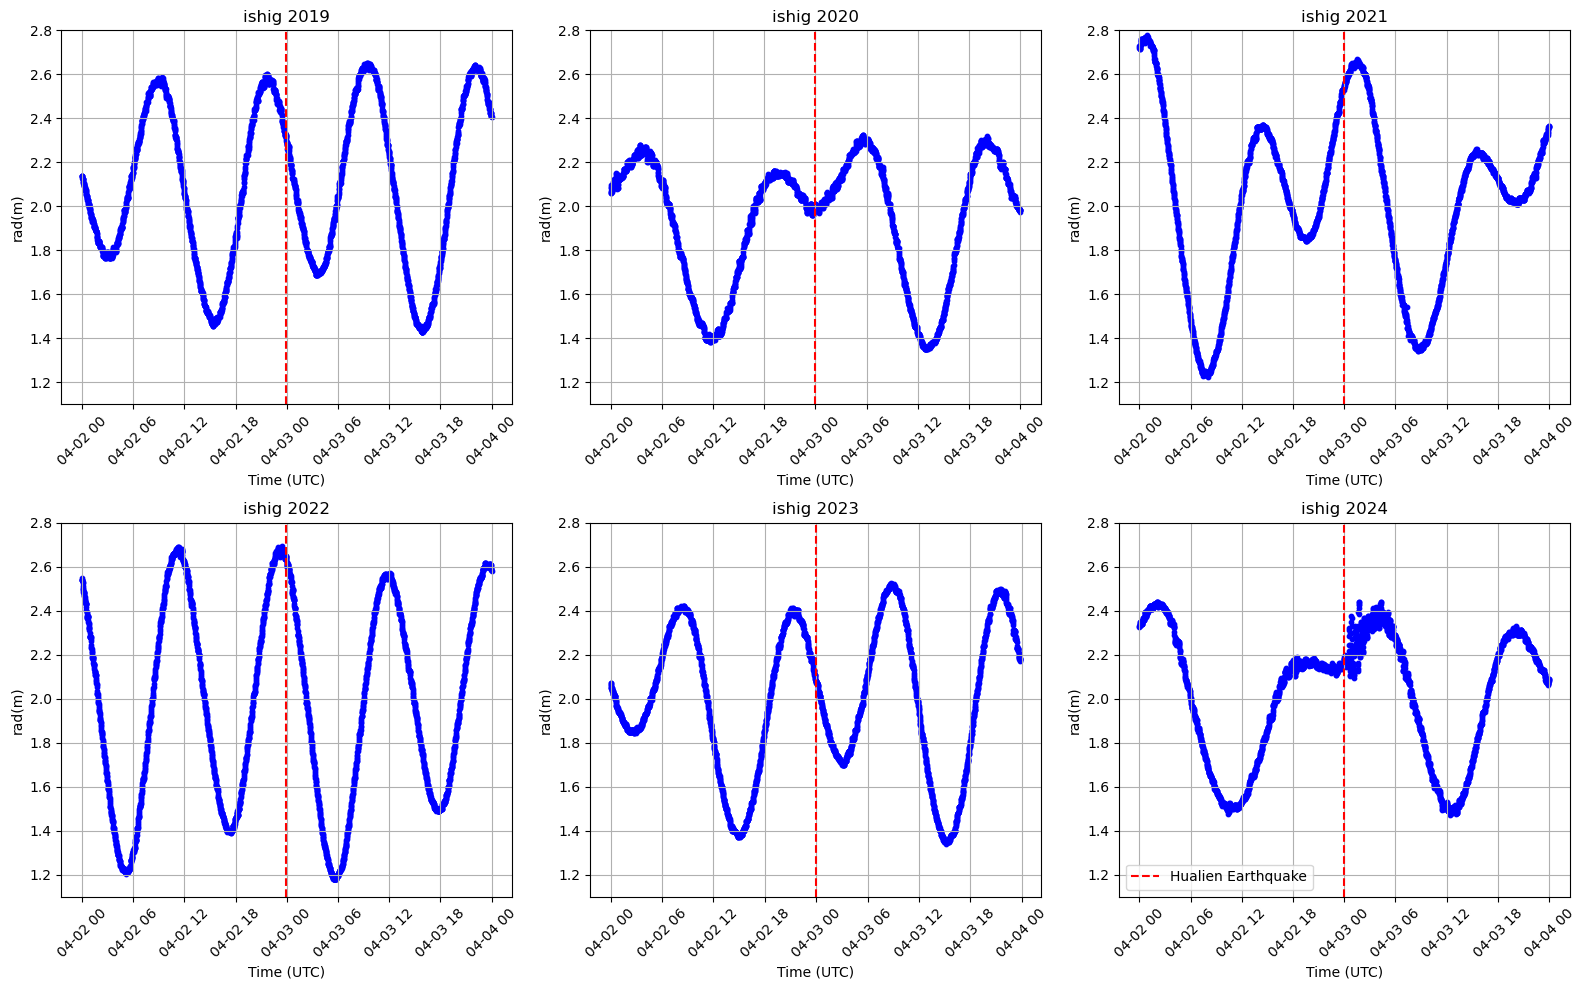

In [67]:
fig, axs = plt.subplots(2, 3, figsize=(16, 10))

# Convert event time to datetime object
event_time = pd.to_datetime('2024-04-02 23:58:12')

locations = [(ishig2019, 'ishig 2019'), (ishig2020, 'ishig 2020'), (ishig2021, 'ishig 2021'), (ishig2022, 'ishig 2022'), (ishig2023, 'ishig 2023'), (ishig, 'ishig 2024')]
# Plot data for each location
for i, (data, location) in enumerate(locations):
    row = i // axs.shape[1]
    col = i % axs.shape[1]
    axs[row, col].scatter(data['Time (UTC)'], data['rad(m)'], marker='o', color='blue', s=10)
    axs[row, col].set_title(location)
    axs[row, col].tick_params(axis='x', rotation=45)  # Rotate x-axis labels
    axs[row, col].set_xlabel('Time (UTC)')
    axs[row, col].set_ylabel('rad(m)')
    axs[row, col].grid(True)

    axs[row, col].set_ylim(1.1, 2.8)
    axs[row, col].axvline(x=event_time, color='red', linestyle='--', label='Hualien Earthquake')

# Add legend
axs[-1, 2].legend(loc='lower left')

# Adjust layout
plt.tight_layout()
plt.show()

# add Discussion